In [207]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import Dissim, MinMax
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
YEARS = [1880, 1883, 1885, 1888, 1890, 1895, 1900, 1902, 1905, 1910, 1913, 1915]
BAD_YEARS = [1885, 1890, 1905, 1910]
BWS = 150, 200, 250
CELL_SIZE = 20

AREAS = {
    'Valli': ['Valli', 'Valli_uusi'],
    'New suburbs': ['Pietarin_esikaupunki', 'Repola', 'Anina', 'Papula', 'Pantsarlahti', 'Salakkalahti'],
    'All suburbs': ['Viipurin_esikaupunki', 'Pietarin_esikaupunki', 'Repola', 'Anina', 'Papula', 'Pantsarlahti', 'Salakkalahti'],
    'Vyborg suburb': ['Viipurin_esikaupunki'],
    'Valli, new': ['Valli_uusi'],
    'Valli, old': ['Valli'],
}

In [208]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
        bounds: tuple,
        pad=0,
):
    pop = get_xy(data)

    minx, miny, maxx, maxy = bounds
    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad
    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)
    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': density.dtype,
        'width': density.shape[1],
        'height': density.shape[0],
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        **kwargs
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bounds=data.geometry.total_bounds,
        pad=50,
        **kwargs
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bounds=data.geometry.total_bounds,
        pad=50,
        **kwargs
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [209]:

def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]

    for idx in institutions.index:
        pop_data = pop_data.drop(index=idx, errors='ignore')

    return pop_data


def handle_combined_plots(
        pop_data: pd.DataFrame,
        target_column: str = 'plot_number',
):
    target_shape = pop_data.shape
    index_columns = pop_data.index.names
    pop_data.reset_index(inplace=True)
    pop_data[target_column] = [e.split(',')[0].strip() for e in pop_data[target_column]]
    pop_data.set_index(index_columns, inplace=True)

    assert pop_data.shape == target_shape

    return pop_data


def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:
    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)
    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)
    return pop_frame


In [210]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [211]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

In [212]:
warnings.simplefilter(action='ignore')

district_codes = pd.read_csv(DATA_DIR / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(DATA_DIR / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(DATA_DIR / 'raw' / 'plots_1878.gpkg').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(DATA_DIR / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

In [213]:
results_dict = {}
for year in YEARS:
    s_ = []
    if year in BAD_YEARS:
        continue
    for bw in BWS:
        population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)

        for group in 'orthodox', 'lutheran', 'total':
            file = DATA_DIR / 'processed' / f"{group}_density_{year}_{bw}m.tif"
            if file.exists():
                continue
            
            density, raster_args = kernel_density_surface(
                page_location_data,
                group=group,
                bandwidth=bw,
                cell_size=CELL_SIZE,
                kernel_function=quartic_kernel,
                bounds=page_location_data.geometry.total_bounds,
            )
            density = density * 10_000

            with rio.open(file, 'w', **raster_args) as rfile:
                rfile.write(density, 1)
        
        S = get_S(
            data=page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel, 
        )
        s_.append(S.statistic)

    results_dict[year] = s_

results = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=BWS,
)

3.26027397260274


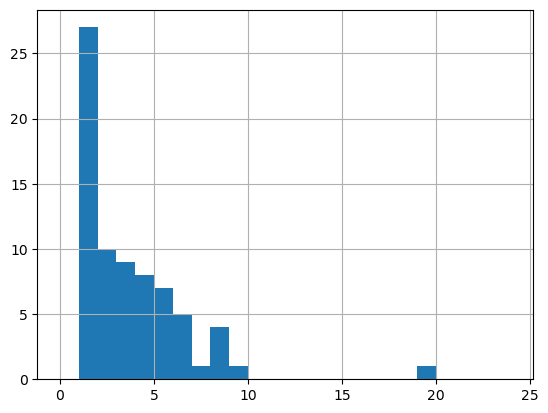

2.738095238095238


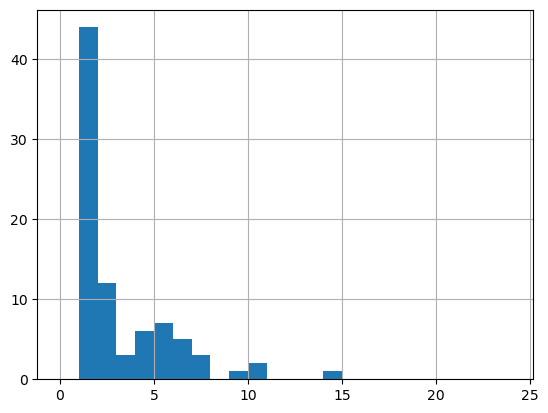

3.217821782178218


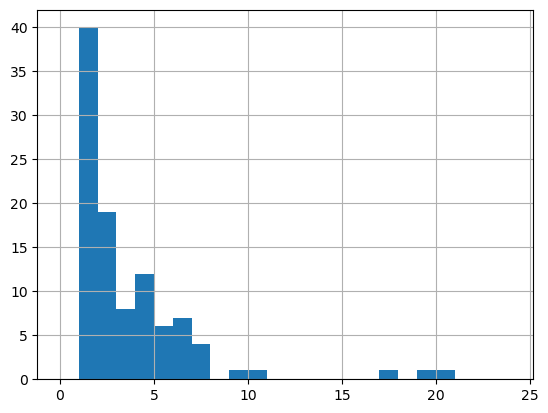

In [214]:
results_dict = {}
for year in (1880, 1900, 1915):
    s_ = []
    
    population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_plot_{year}.csv',
        index_col=0,
        dtype={'district': str, 'plot_number': str},
    ).pipe(prepare_pop_data)
    population_data = population_data.set_index(['district', 'plot_number'], drop=True)
    population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
    combined_data = location_data.join(population_data, on=['district', 'plot_number'])
    combined_data.dropna(axis=0, inplace=True)
    valli_data = combined_data.loc[AREAS['Valli']].copy()
    print(valli_data.orthodox.sum() / sum(valli_data.orthodox > 0))
    valli_data.orthodox.loc[valli_data.orthodox > 0].hist(bins=list(range(0,25,1)))
    plt.show()
    for bw in BWS:
        for group in 'orthodox', 'lutheran', 'total':
            file = DATA_DIR / 'processed' / f"{group}_density_Valli_{year}_{bw}m.tif"
            if file.exists():
                continue
            density, raster_args = kernel_density_surface(
                valli_data,
                group=group,
                bandwidth=bw,
                cell_size=CELL_SIZE,
                kernel_function=quartic_kernel,
                bounds=valli_data.geometry.total_bounds,
            )
            density = density * 10_000
            with rio.open(file, 'w', **raster_args) as rfile:
                rfile.write(density, 1)
        
        S = get_S(
            data=valli_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        s_.append(S.statistic)

    results_dict[year] = s_

valli_results = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=BWS,
)

In [215]:
# Results by district
results_dict = {}
for year in YEARS:
    if year in BAD_YEARS:
        continue
    bw = 150
    population_data = pd.read_csv(
        DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
        index_col=0,
        dtype={'district': str, 'representative_plot': str, 'page_number': str},
    ).pipe(prepare_pop_data)
    population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
    population_data = population_data.set_index(['district', 'plot_number'], drop=True)
    population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
    page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
    page_location_data.dropna(axis=0, inplace=True)

    s_ = {}
    # for district in page_location_data.index.levels[0]:
        # area_data = page_location_data.loc[district].copy()
    for area, districts in AREAS.items():
        area_data = page_location_data.loc[districts].copy()
        S = get_S(
            data=area_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        s_[area] = S.statistic

    results_dict[year] = s_

results_by_district = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=list(AREAS),
)

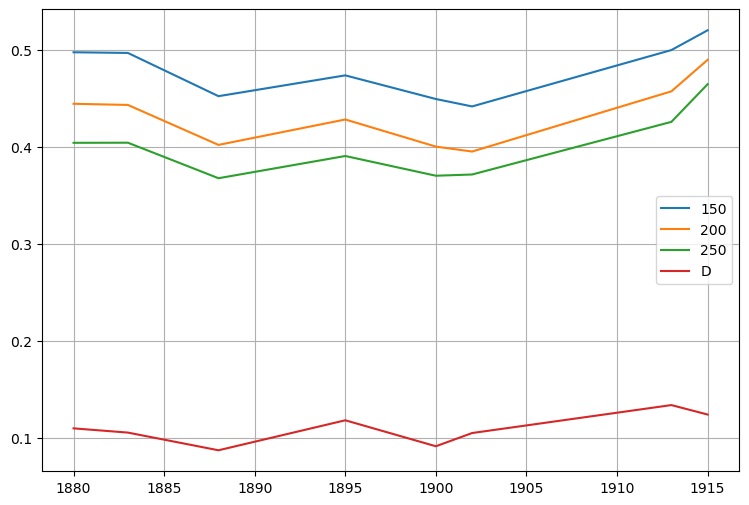

In [216]:
districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

results_D = {}

for year in YEARS:
    if year in BAD_YEARS:
        continue

    population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
    population_data = population_data[population_data.district.isin(districts_in_city)]
    population_data = population_data.loc[:, ['district', 'lutheran', 'orthodox', 'total']].groupby('district').sum()
    totals = pd.Series(population_data.sum(axis=0), name='totals')
    population_data = population_data.append(totals)

    D = Dissim(
        population_data,
        group_pop_var='orthodox',
        total_pop_var='total',
    )
    results_D[year] = D.statistic

results['D'] = pd.Series(results_D)
results.to_csv(DATA_DIR / 'processed' / 'results.csv')
# results.drop(labels=BAD_YEARS, axis=0, inplace=True)
results.plot(
    figsize=(9, 6),
    subplots=False,
    grid=True,
)
# for ax in axes:
    # ticks = np.arange(0, 1, 0.05)
    # ax.set_yticks(ticks)
    # ax.autoscale_view()
plt.savefig(FIG_DIR / 'S_and_D.png')

In [217]:
# individual impact

def loo_data_generator(
    data: pd.DataFrame,
):
    for idx in data.index:
        clipped = data.drop(index=idx)
        yield idx, clipped

def individual_impact(
    data: pd.DataFrame,
    **kwargs
)-> pd.Series:
    S_normal = get_S(
        data=data,
        **kwargs
    )
    statistics = {}
    for (idx, clipped_data) in loo_data_generator(data):
        S = get_S(
            data=clipped_data,
            **kwargs
        )
        statistics[idx] = S.statistic
    impact = S_normal.statistic - pd.Series(statistics)
    impact.name = 'S'
    return impact.round(5)

In [218]:
results = {}
for year in YEARS:
    if year in BAD_YEARS:
        continue
    for bw in BWS:
        output_file = DATA_DIR / 'processed' / f'S_impact_{year}_{bw}m.csv'
        if output_file.exists():
            continue
    
        population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)
        impact = individual_impact(
            page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        impact.to_csv(output_file)

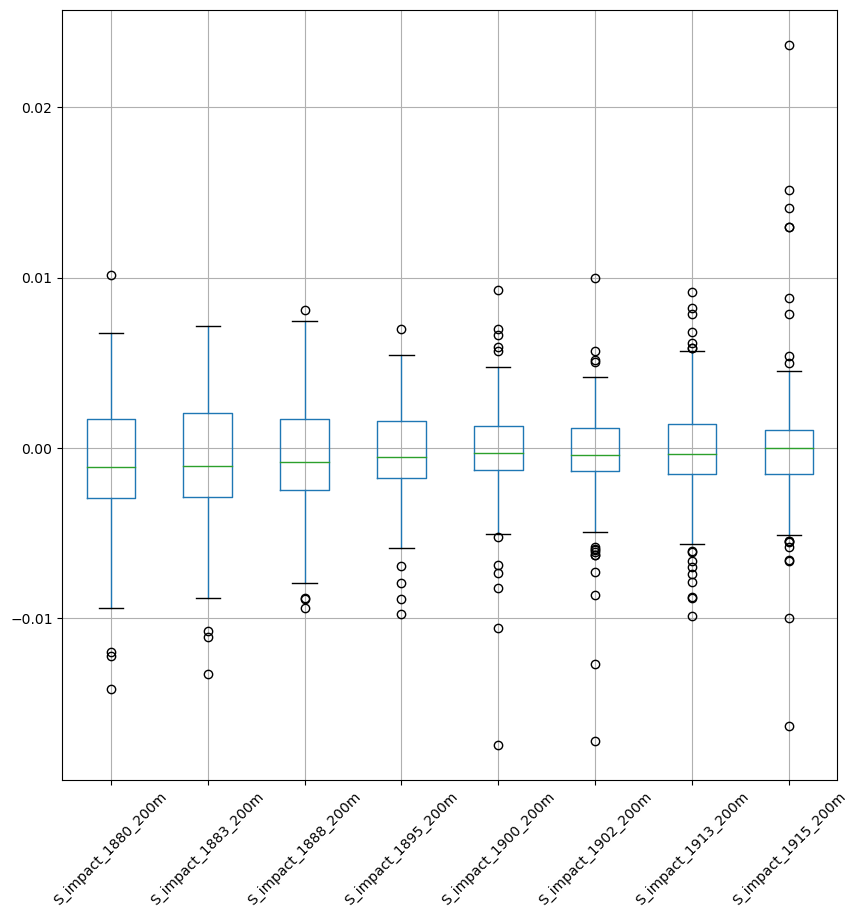

In [219]:
impact_list = []
for file in (DATA_DIR / 'processed').glob('S_impact*200m.csv'):
    impact = pd.read_csv(file, index_col=(0, 1), header=0, names=[file.stem])
    sorted_ = impact.sort_values(by=file.stem)
    impact_list.append(sorted_)

impacts = pd.concat(impact_list)

impacts.boxplot(rot=45, figsize=(10,10))
plt.show()

In [220]:
results = {}
for year in (1880, 1900, 1915):
    for bw in 150,:
        output_file = DATA_DIR / 'processed' / f'S_impact_Valli_{year}_{bw}m.csv'
        if output_file.exists():
            continue
    
        population_data = pd.read_csv(
            DATA_DIR / 'interim' / f'pop_by_plot_{year}.csv',
            index_col=0,
            dtype={'district': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)
        impact = individual_impact(
            page_location_data.loc[AREAS['Valli']].copy(),
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        impact.to_csv(output_file)

                S_impact_Valli_1880_150m
Valli      19                   -0.01478
           90                   -0.01453
           93                   -0.01349
           117                  -0.01342
           63                   -0.01329
...                                  ...
Valli_uusi 166                   0.00887
Valli      134                   0.00925
           24                    0.01182
           34                    0.01440
           39                    0.01763

[122 rows x 1 columns]
                S_impact_Valli_1900_150m
Valli      12                   -0.02634
           50                   -0.02624
           75                   -0.02550
           9                    -0.02252
           46                   -0.01706
...                                  ...
           34                    0.00757
Valli_uusi 178                   0.01711
Valli      33                    0.01844
           44                    0.02838
           39                    

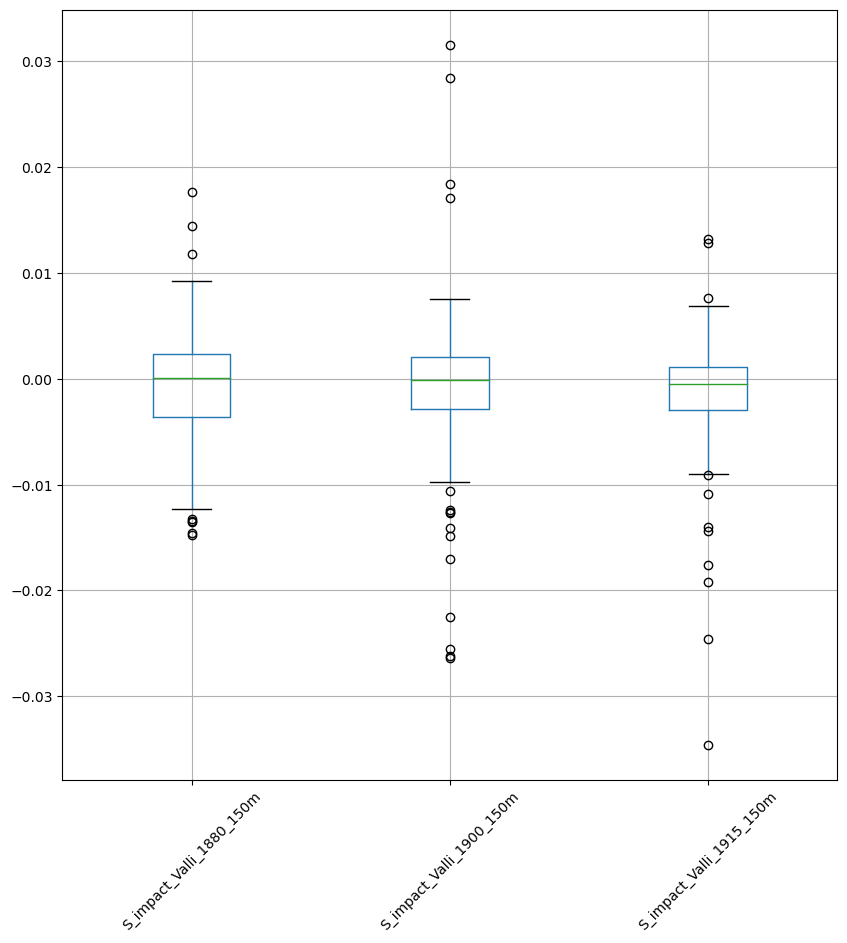

In [221]:
impact_list = []
for file in (DATA_DIR / 'processed').glob('S_impact_Valli*150m.csv'):
    impact = pd.read_csv(file, index_col=(0, 1), header=0, names=[file.stem])
    sorted_ = impact.sort_values(by=file.stem)
    impact_list.append(sorted_)
    print(sorted_)

impacts = pd.concat(impact_list)

impacts.boxplot(rot=45, figsize=(10,10))
plt.show()

<AxesSubplot: >

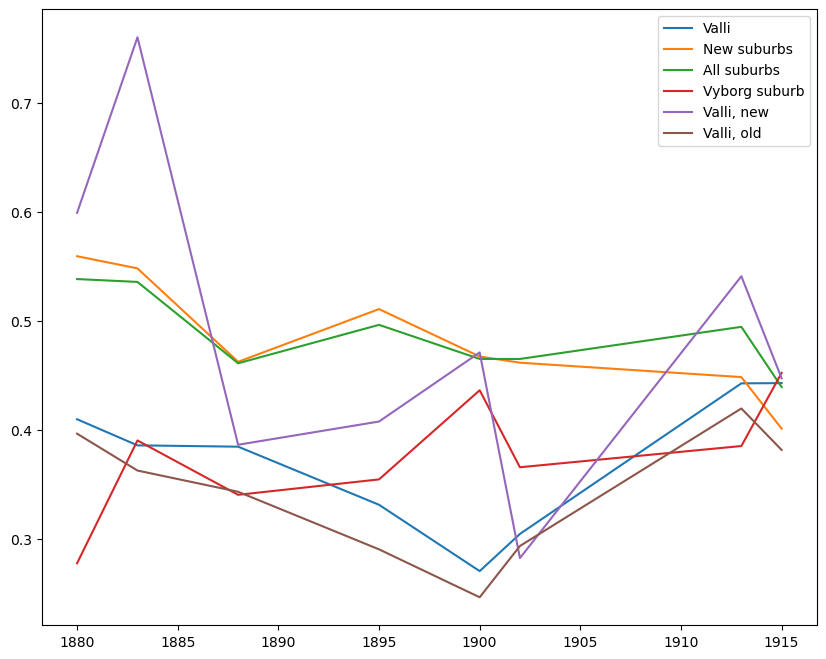

In [222]:
results_by_district.plot(figsize=(10, 8))

In [223]:
import arviz as az
import pymc as pm
from patsy import dmatrix

regression_data = pd.read_csv(DATA_DIR / 'processed' / 'results.csv', index_col=0)
regression_data.loc[regression_data.index.isin(BAD_YEARS),:] = np.nan
regression_data = regression_data.dropna(axis=0)
n_knots = 3

knot_list = np.linspace(regression_data.index.min(), regression_data.index.max(), n_knots)
B = dmatrix(
    "bs(year, knots=knots, degree=2, include_intercept=True) - 1",
    {"year": regression_data.index, "knots": knot_list[1:-1]},
)

Text(0, 0.5, 'basis')

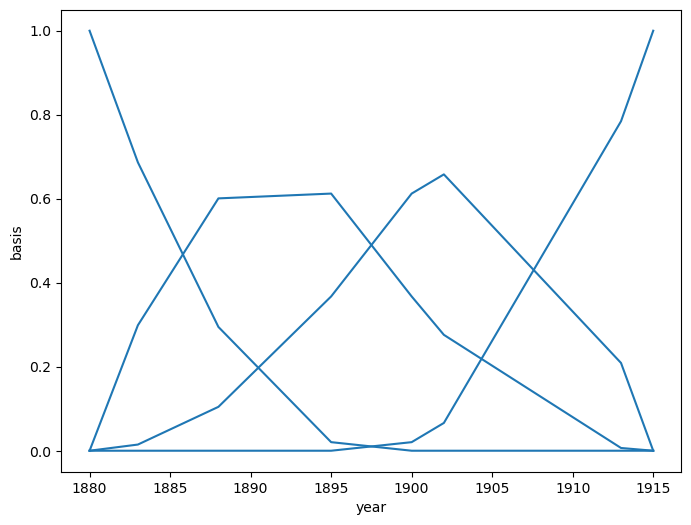

In [224]:
# Basis
_, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(n_knots + 1):
    ax.plot(regression_data.index, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis")

In [225]:
μ_w = [0] * (n_knots + 1)
with pm.Model() as model:
    a = pm.Normal("a", 0.45, 0.05)
    w = pm.Normal("w", mu=μ_w, sigma=0.05, shape=B.shape[1])
    μ = pm.Deterministic("μ", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    σ = pm.HalfNormal('σ', 0.05)
    S = pm.Normal("S", μ, σ, observed=regression_data['200'])
    idata = pm.sample(1000, tune=1000, chains=2)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [226]:
with model:
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(idata)

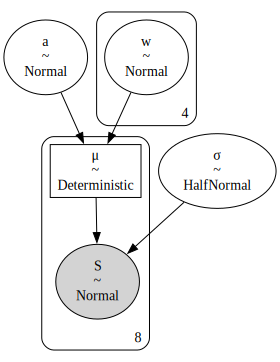

In [227]:
graph = pm.model_to_graphviz(model)
graph.format = 'svg'
graph.render(FIG_DIR / 'plate_diagram')
graph

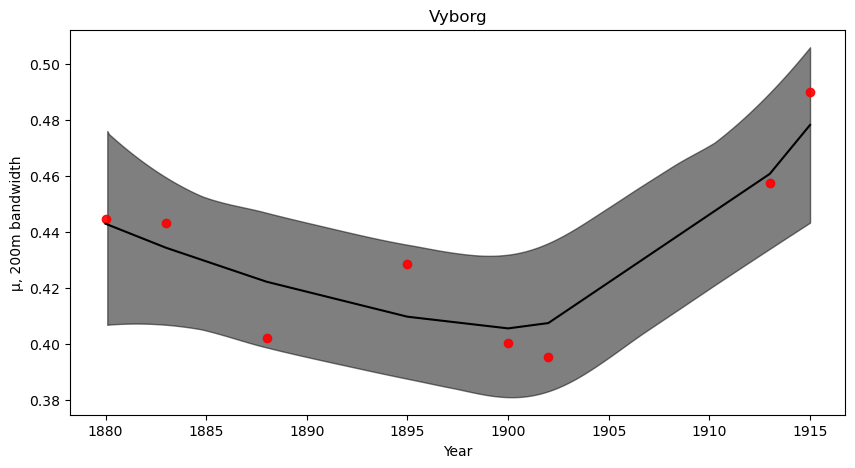

In [228]:
# Posterior mean
ax = az.plot_hdi(regression_data.index, idata["posterior"]["μ"], color="k", hdi_prob=0.95)
ax.plot(regression_data.index, regression_data["200"], "o", c='red', alpha=0.9)
ax.plot(regression_data.index, idata["posterior"]["μ"].mean(axis=(0,1)), c='black')
fig = plt.gcf()
fig.set_size_inches(10, 5)
# ax.set_ylim(0, 1600)
ax.set_xlabel("Year")
ax.set_ylabel("μ, 200m bandwidth")
ax.set_title("Vyborg")
plt.savefig(FIG_DIR / 'total.png')
plt.show()

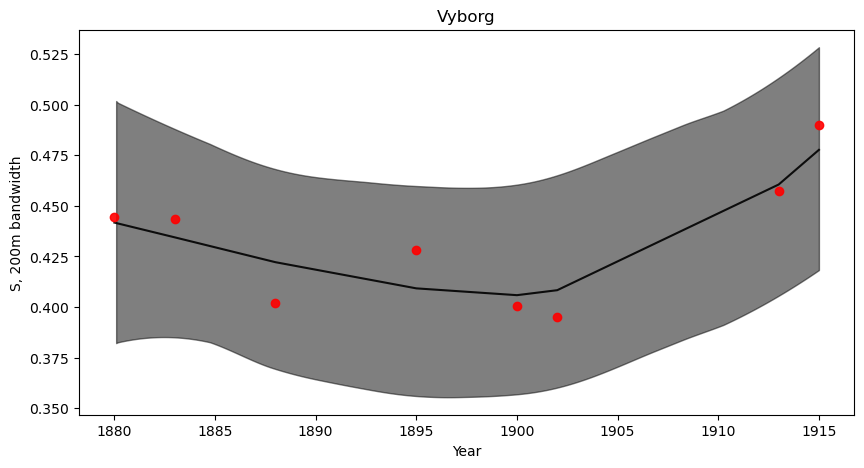

In [229]:
# Posterior predictive
ax = az.plot_hdi(regression_data.index, posterior["posterior_predictive"]["S"], color="k", hdi_prob=0.95)
ax.plot(regression_data.index, posterior["posterior_predictive"]["S"].mean(axis=(0,1)), c='black', alpha=0.9)
ax.plot(regression_data.index, regression_data["200"], "o", c='red', alpha=0.9)
fig = plt.gcf()
fig.set_size_inches(10, 5)
# ax.set_ylim(0, 1600)
ax.set_xlabel("Year")
ax.set_ylabel("S, 200m bandwidth")
ax.set_title("Vyborg")
plt.show()

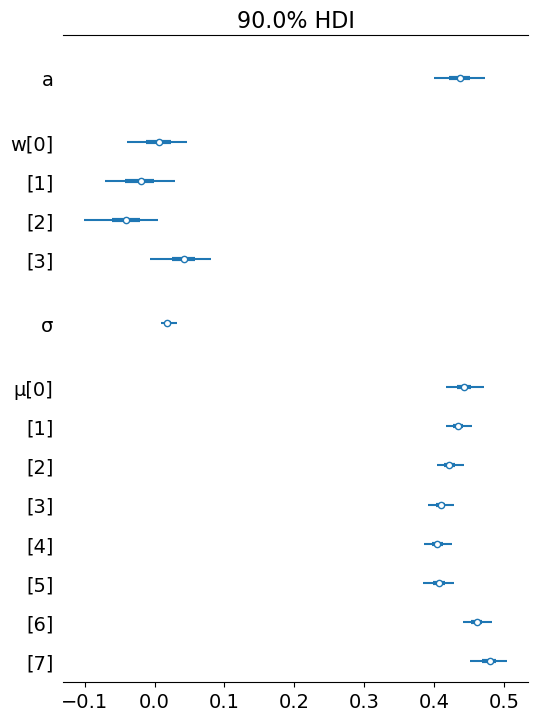

In [230]:
az.plot_forest(idata, hdi_prob=0.9, combined=True)
plt.show()

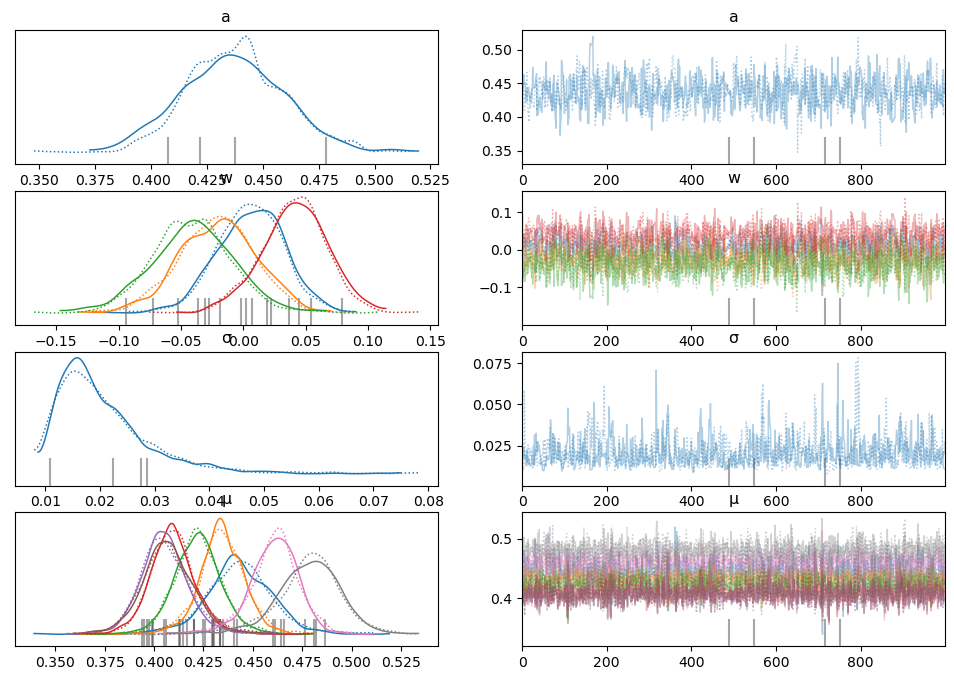

In [231]:
az.plot_trace(idata)
plt.show()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


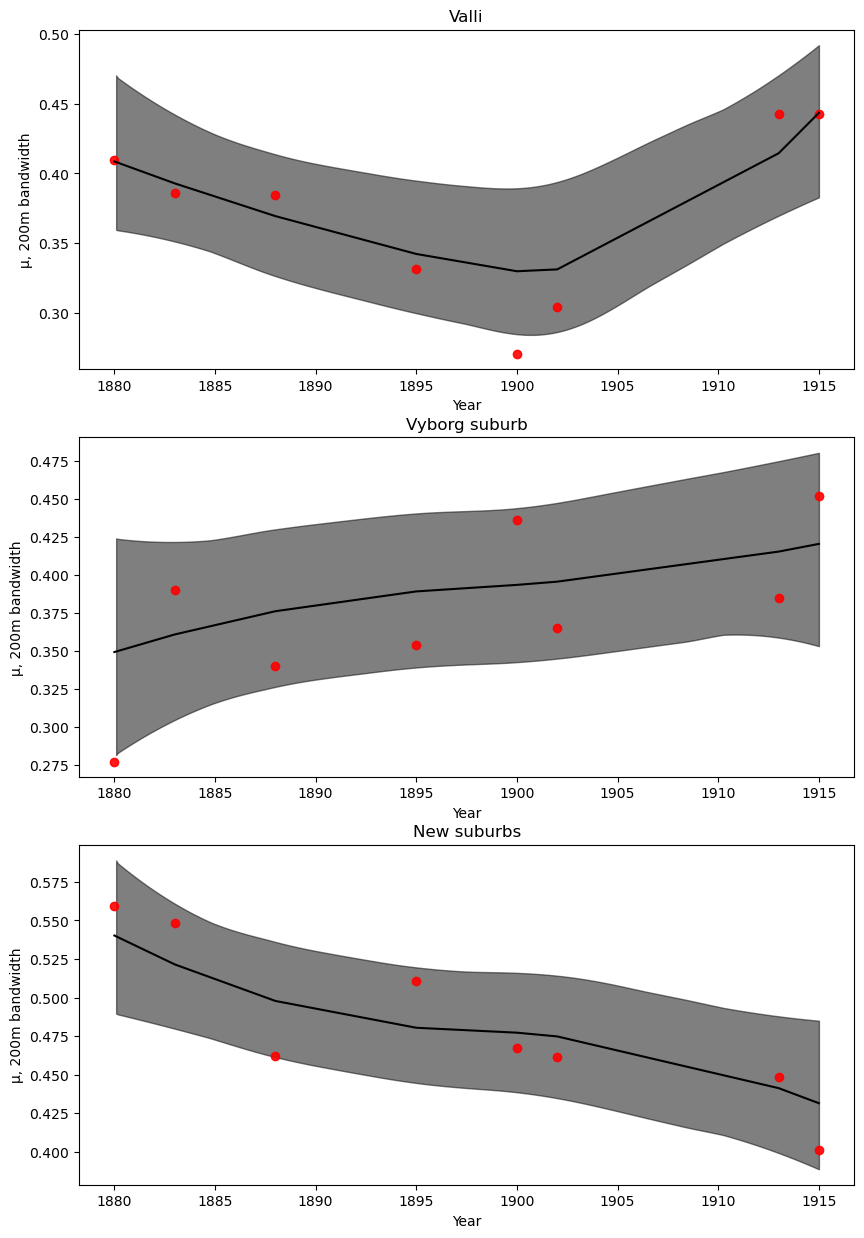

In [234]:
areas = ["Valli", "Vyborg suburb", "New suburbs"]
fig, axs = plt.subplots(
    ncols=1, 
    nrows=len(areas), 
    figsize=(10, 5 * len(areas)),
)

for i, area in enumerate(areas): 
    μ_w = [0] * (n_knots + 1)
    with pm.Model() as model_area:
        a = pm.Normal("a", 0.5, 0.05)
        w = pm.Normal("w", mu=μ_w, sigma=0.05, shape=B.shape[1])
        μ = pm.Deterministic("μ", a + pm.math.dot(np.asarray(B, order="F"), w.T))
        σ = pm.HalfNormal('σ_0', 0.05)
        S = pm.Normal("S", μ, σ, observed=results_by_district[area])
        idata_area = pm.sample(1000, tune=1000, chains=2)

    az.plot_hdi(regression_data.index, idata_area["posterior"]["μ"], color="k", hdi_prob=0.95, ax=axs[i])
    axs[i].plot(regression_data.index, results_by_district[area], "o", c='red', alpha=0.9)
    axs[i].plot(regression_data.index, idata_area["posterior"]["μ"].mean(axis=(0,1)), c='black')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("μ, 200m bandwidth")
    axs[i].set_title(area)

plt.savefig(FIG_DIR / 'all.png')
plt.show()

<AxesSubplot: >

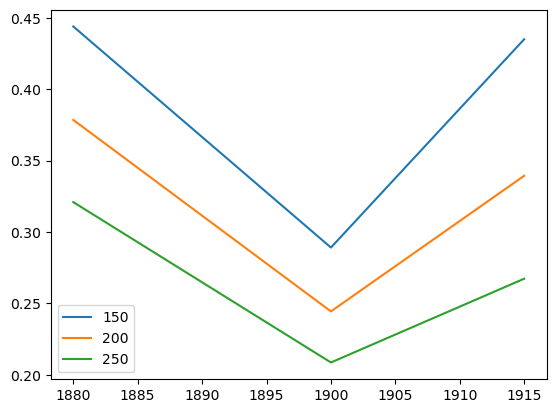

In [233]:
valli_results.plot()